# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. 

<b><u>Цель:</u></b>
Построить модель для определения стоимости автомобиля

<b><u>Инструкции:</u></b>

В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
# !pip install python-pip -U -q
# !pip install numba==0.59.1 -q
# !pip install scipy -U -q
# !pip install numpy==1.23.1 -q

# !pip install matplotlib -U -q
# !pip install seaborn -U -q
# !pip install phik -U -q
# !pip install shap -U -q
# !pip install scikit-learn -U -q
# !pip install pandas==2.2.2 -q
# !pip install jinja2==3.1.2 -q

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder,  StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, root_mean_squared_error

import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
import time

RANDOM_STATE = 123

In [3]:
project_path_01 = "C:\\Users\\kushn\\Documents\\Python_trainings\\Yandex_DS\\Gradient_boosting\\"
project_path_02 = "/datasets/"

In [4]:
if os.path.exists(project_path_01):
    data = pd.read_csv(project_path_01 + 'autos.csv')
elif os.path.exists(project_path_02):
    data = pd.read_csv(project_path_02 + 'autos.csv')
else:
    print("Smth wrong")

In [5]:
def df_info (df):
        print(df.info())
        return df.head()

In [6]:
df_info(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


проверим полные дубли

In [7]:
data.duplicated().sum(), data.shape

(4, (354369, 16))

удалим полные дубли

In [8]:
data.drop_duplicates(inplace=True)
data.shape

(354365, 16)

оценим тип данных и пропуски

In [9]:
def output_info(df):
    output = []
    for col in df.columns:
        nul = df[col].isna().sum()
        non_nul = len(df) - nul
        n_uniq = df[col].nunique()
        col_type = str(df[col].dtype)
        output.append([col, nul, non_nul, n_uniq, col_type])
    output = pd.DataFrame(output)
    output.columns = [
        'col_names', 'null_values','non-null_values', 'unique_amount', 'dtype']
    return output

In [10]:
output_info(data)

,col_names,null_values,non-null_values,unique_amount,dtype
0,DateCrawled,0,354365,271174,object
1,Price,0,354365,3731,int64
2,VehicleType,37490,316875,8,object
3,RegistrationYear,0,354365,151,int64
4,Gearbox,19833,334532,2,object
5,Power,0,354365,712,int64
6,Model,19705,334660,250,object
7,Kilometer,0,354365,13,int64
8,RegistrationMonth,0,354365,13,int64
9,FuelType,32895,321470,7,object


Пропуски в категориальных данных 
- VehicleType	
- Gearbox
- Model
- FuelType
- Repaired

Заполним их самым часто встречающимся значением в пайплайне

Следующие признаки  удаляем, поскольку являются неинформативными 
- DateCrawled	
- RegistrationMonth
- DateCreated
- NumberOfPictures	
- LastSeen
- PostalCode

In [11]:
data.drop(columns=['NumberOfPictures',
                   'DateCrawled',
                    'RegistrationMonth',
                    'DateCreated',
                    'PostalCode',
                    'LastSeen'], inplace=True)

## EDA

In [12]:
def eda_graph (column, bins):
    plt.figure(figsize=(15,10))
    sns.histplot(x=column, data=data, bins=bins)
    plt.title('Гистограмма признака ' + column)
    plt.ylabel('Количество значений')
    plt.xlabel(column)
    plt.show()

### Price

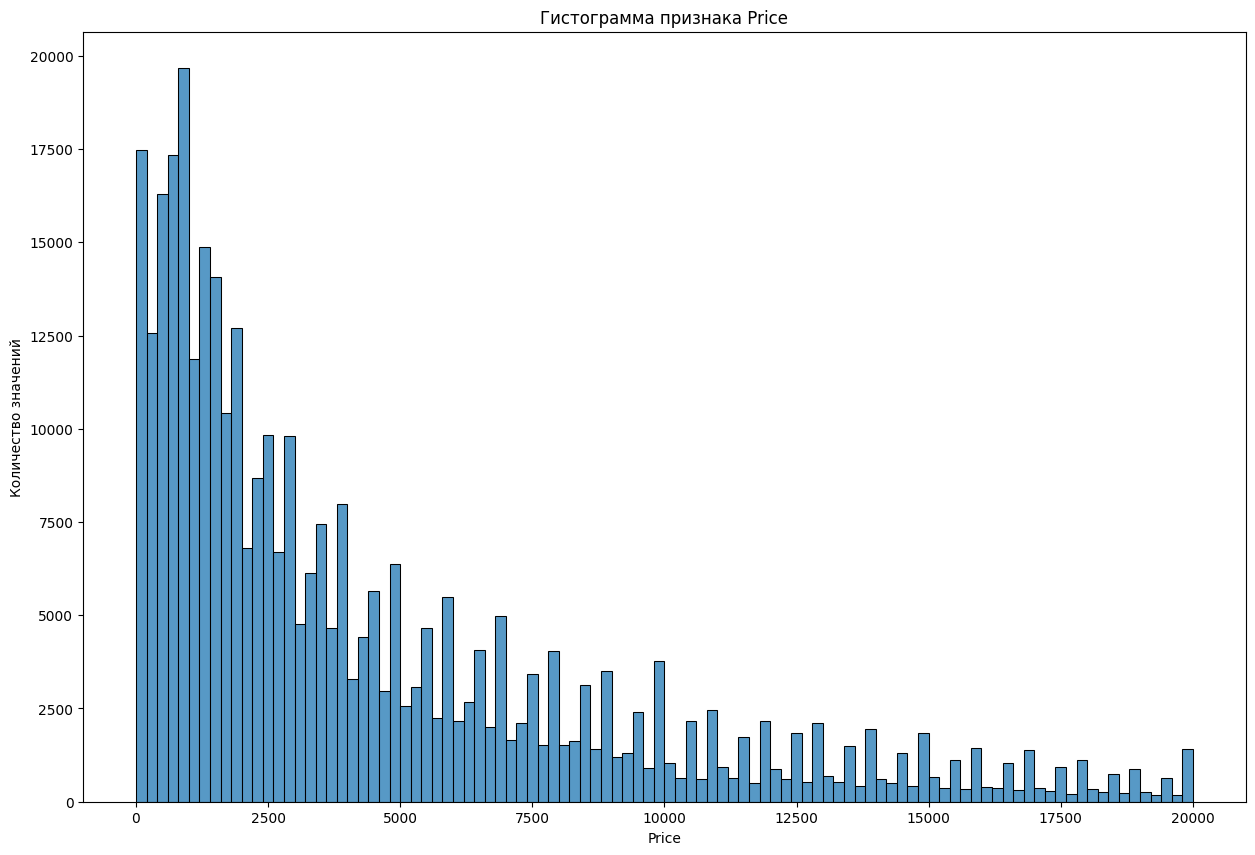

In [13]:
eda_graph('Price', 100)

In [14]:
data.Price.describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

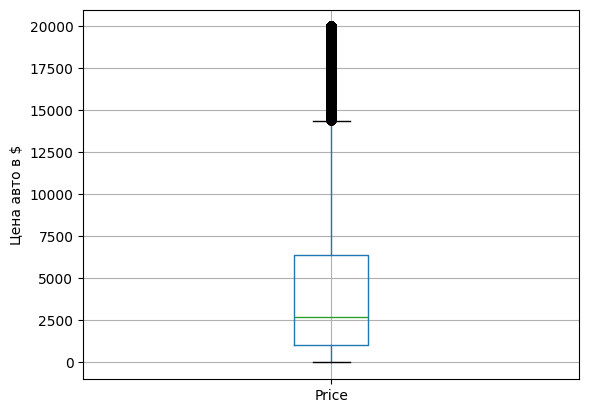

In [15]:
data.boxplot(column='Price', return_type='both')
plt.ylabel('Цена авто в $')
plt.show()

Слишком много машин с 0 ценой. Удалим значения меньше 10 долларов.

In [16]:
mask = data.loc[(data.loc[:, 'Price'] < 1000)].index

len(mask), data.shape

(83326, (354365, 10))

In [17]:
data.drop(mask, inplace=True)
data.shape

(271039, 10)

### VehicleType

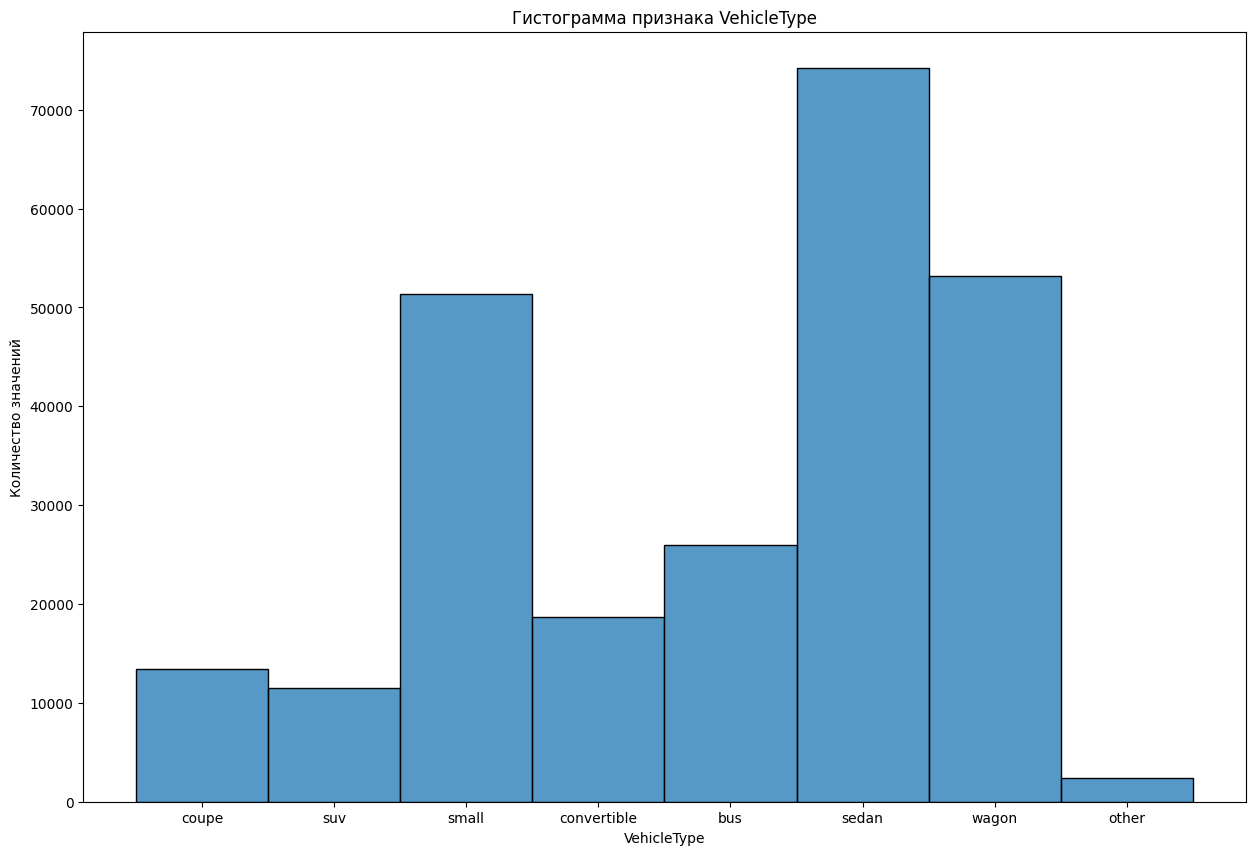

In [18]:
eda_graph('VehicleType', 8)

### RegistrationYear

In [19]:
np.sort(data.RegistrationYear.unique())

array([1000, 1001, 1039, 1234, 1500, 1600, 1800, 1910, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2500, 2800, 2900, 3000, 3200, 3700, 4000, 4100,
       4500, 5000, 5555, 5911, 6000, 7000, 7100, 7800, 8500, 8888, 9000,
       9999], dtype=int64)

Удалим года меньше 1910 и больше 2018

In [20]:
mask = data.loc[(data.loc[:, 'RegistrationYear'] < 1910) \
         | (data.loc[:, 'RegistrationYear'] > 2016)].index

len(mask), data.shape

(10643, (271039, 10))

In [21]:
data.drop(mask, inplace=True)
data.shape

(260396, 10)

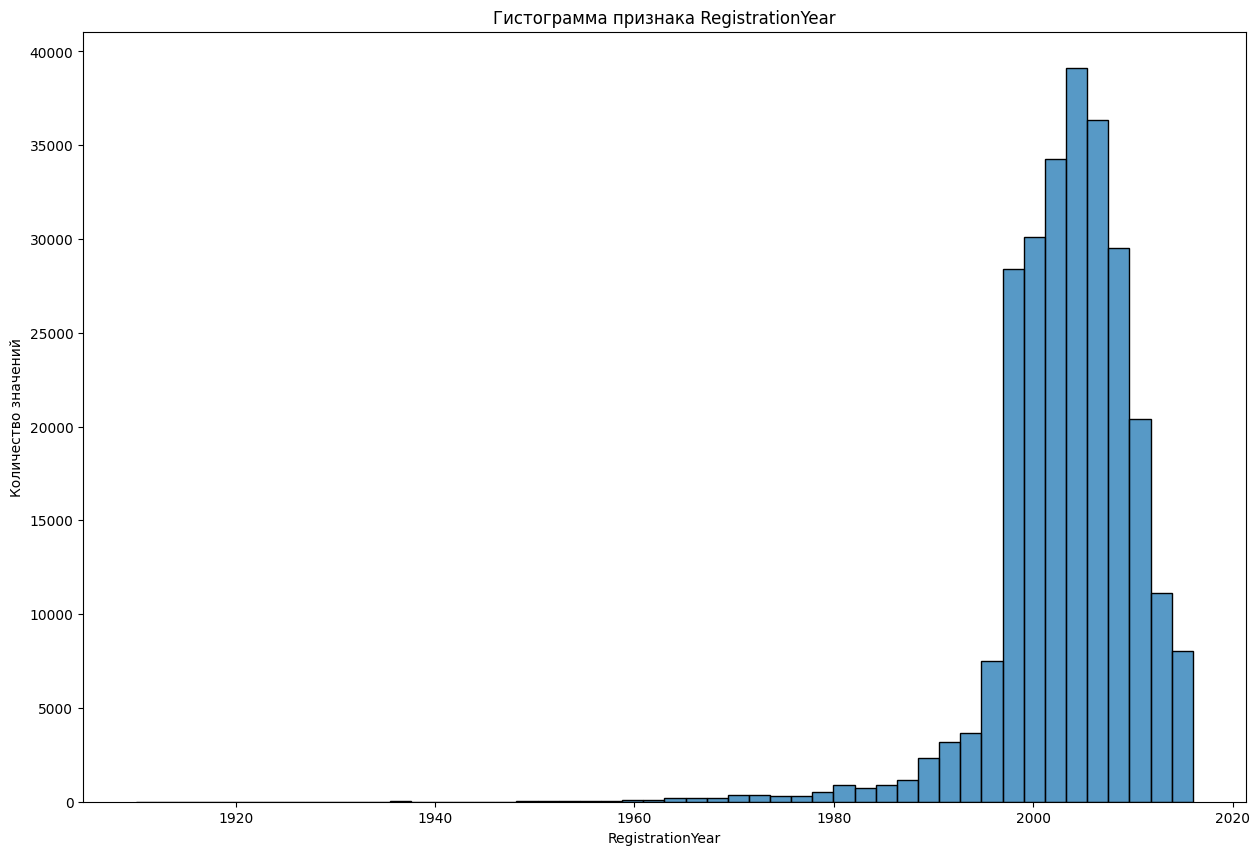

In [22]:
eda_graph('RegistrationYear', 50)

### Gearbox 

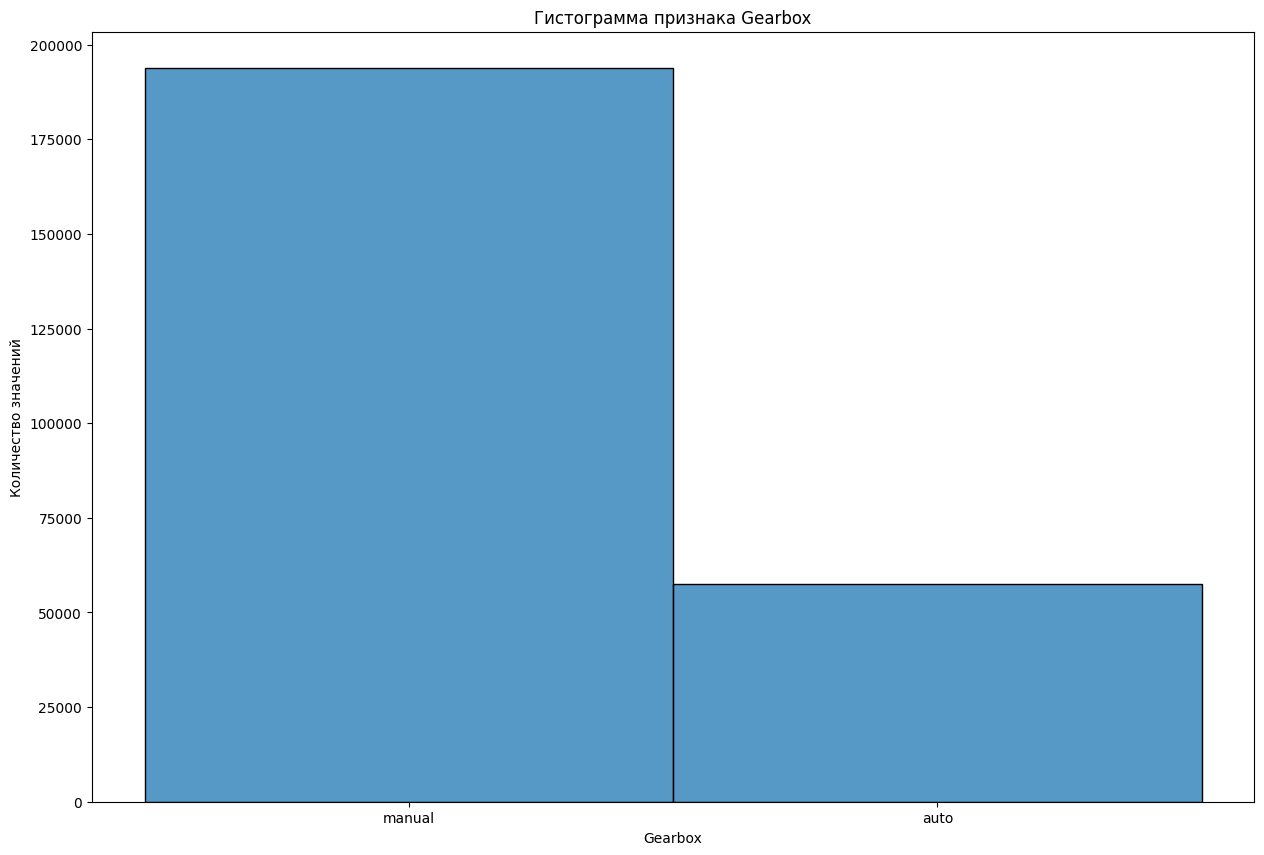

In [23]:
eda_graph('Gearbox',2)

### Power

In [24]:
data.Power.describe()

count    260396.000000
mean        122.357164
std         189.865425
min           0.000000
25%          80.000000
50%         116.000000
75%         150.000000
max       20000.000000
Name: Power, dtype: float64

удалим значения с аномальной мощностью равной 0 и более 1000 л.с.

In [25]:
mask = data.loc[(data.loc[:, 'Power'] < 50)|(data.loc[:, 'Power'] > 1000)].index

len(mask), data.shape

(21149, (260396, 10))

In [26]:
data.drop(mask, inplace=True)
data.shape

(239247, 10)

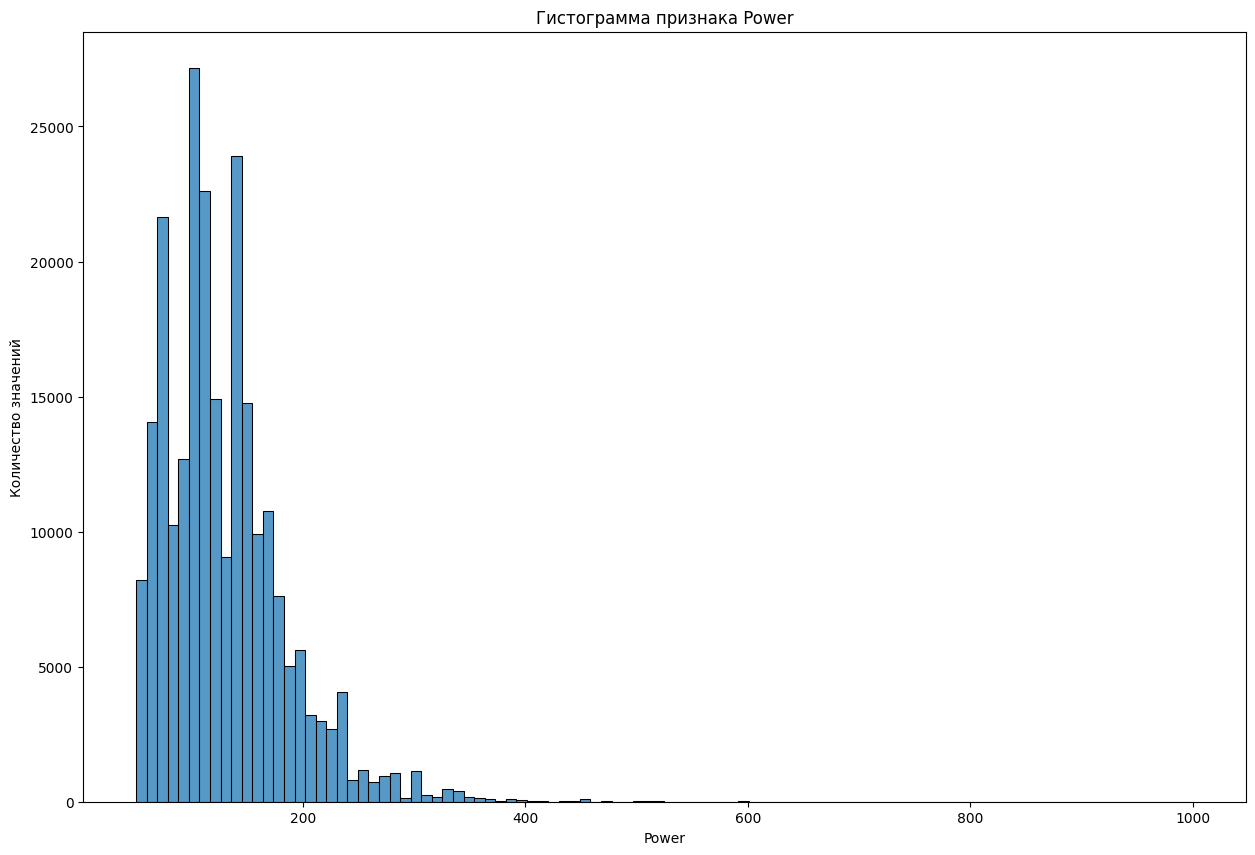

In [27]:
eda_graph('Power', 100)

### Model

In [28]:
data.Model.value_counts()[:10]

Model
golf        19759
other       16038
3er         15372
a4           7808
passat       7583
polo         6698
astra        6674
5er          6672
c_klasse     6596
corsa        5621
Name: count, dtype: int64

### Kilometer

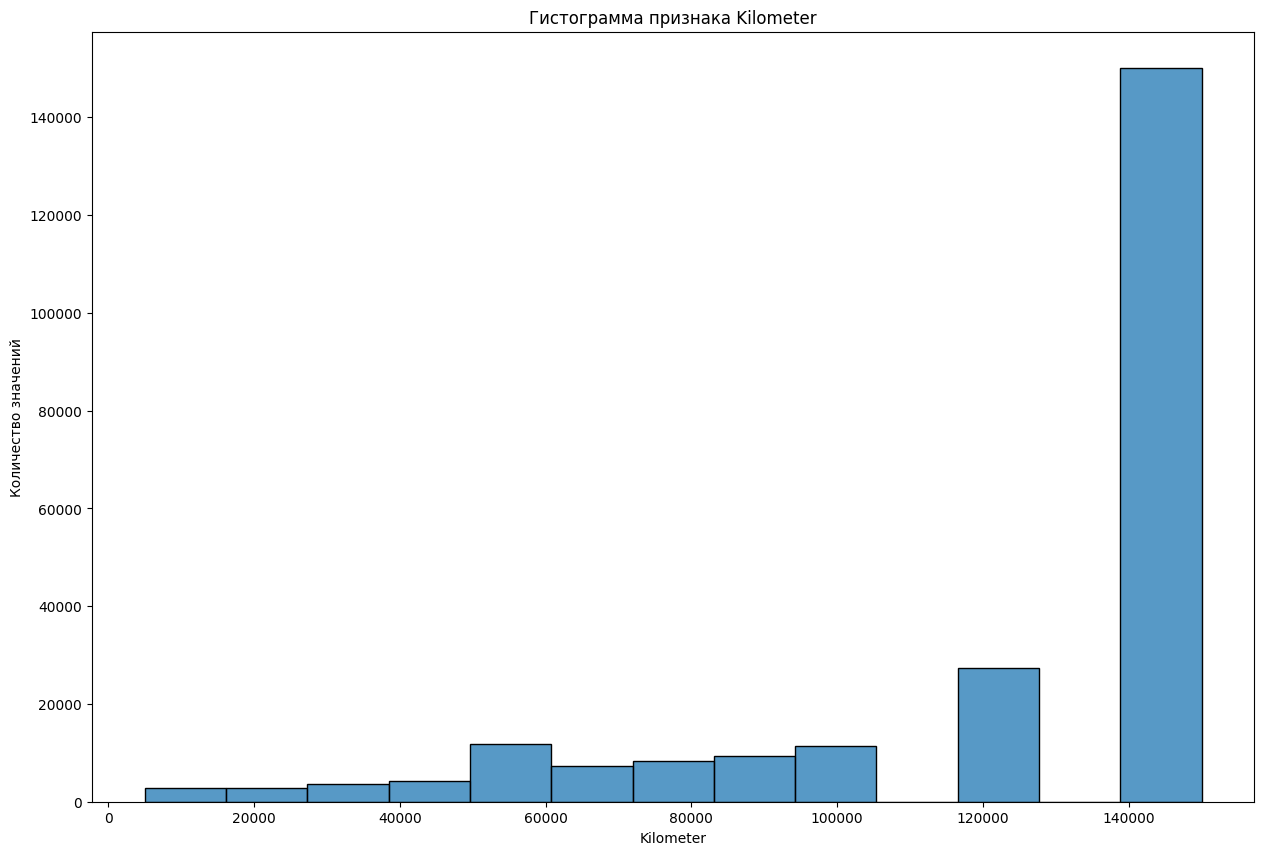

In [29]:
eda_graph('Kilometer', 13)

### FuelType

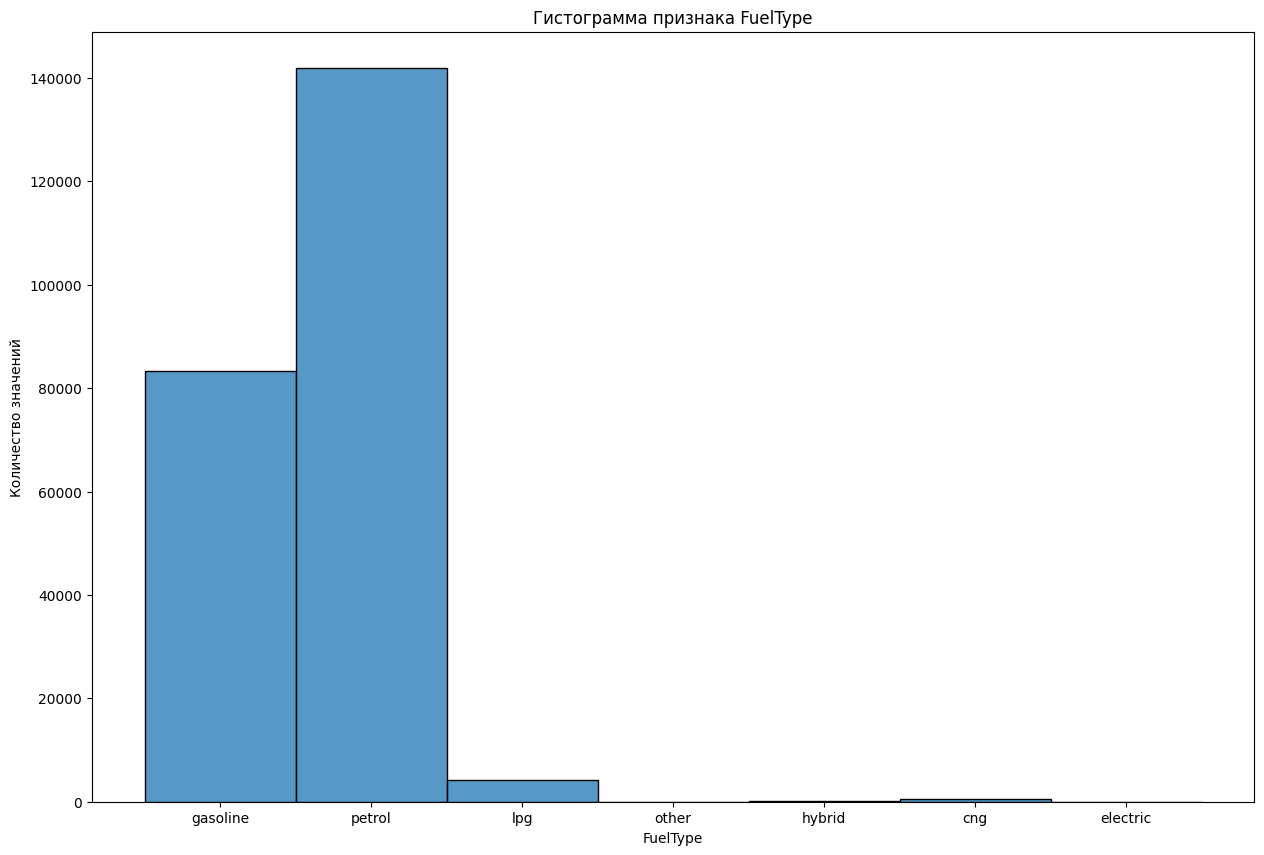

In [30]:
eda_graph('FuelType',7)

### Brand

In [31]:
data.Brand.value_counts(normalize=True).map("{:.1%}".format)

Brand
volkswagen        21.6%
bmw               12.3%
mercedes_benz     10.6%
audi               9.6%
opel               9.3%
ford               6.1%
renault            3.8%
peugeot            3.1%
fiat               2.1%
skoda              2.0%
seat               1.9%
toyota             1.6%
mazda              1.5%
smart              1.4%
citroen            1.4%
nissan             1.2%
mini               1.2%
hyundai            1.2%
volvo              0.9%
honda              0.8%
kia                0.8%
mitsubishi         0.7%
alfa_romeo         0.7%
suzuki             0.7%
sonstige_autos     0.6%
chevrolet          0.6%
chrysler           0.4%
dacia              0.3%
porsche            0.3%
jeep               0.2%
land_rover         0.2%
subaru             0.2%
jaguar             0.2%
saab               0.2%
daihatsu           0.1%
lancia             0.1%
daewoo             0.1%
rover              0.1%
lada               0.1%
trabant            0.0%
Name: proportion, dtype: object

### Repaired

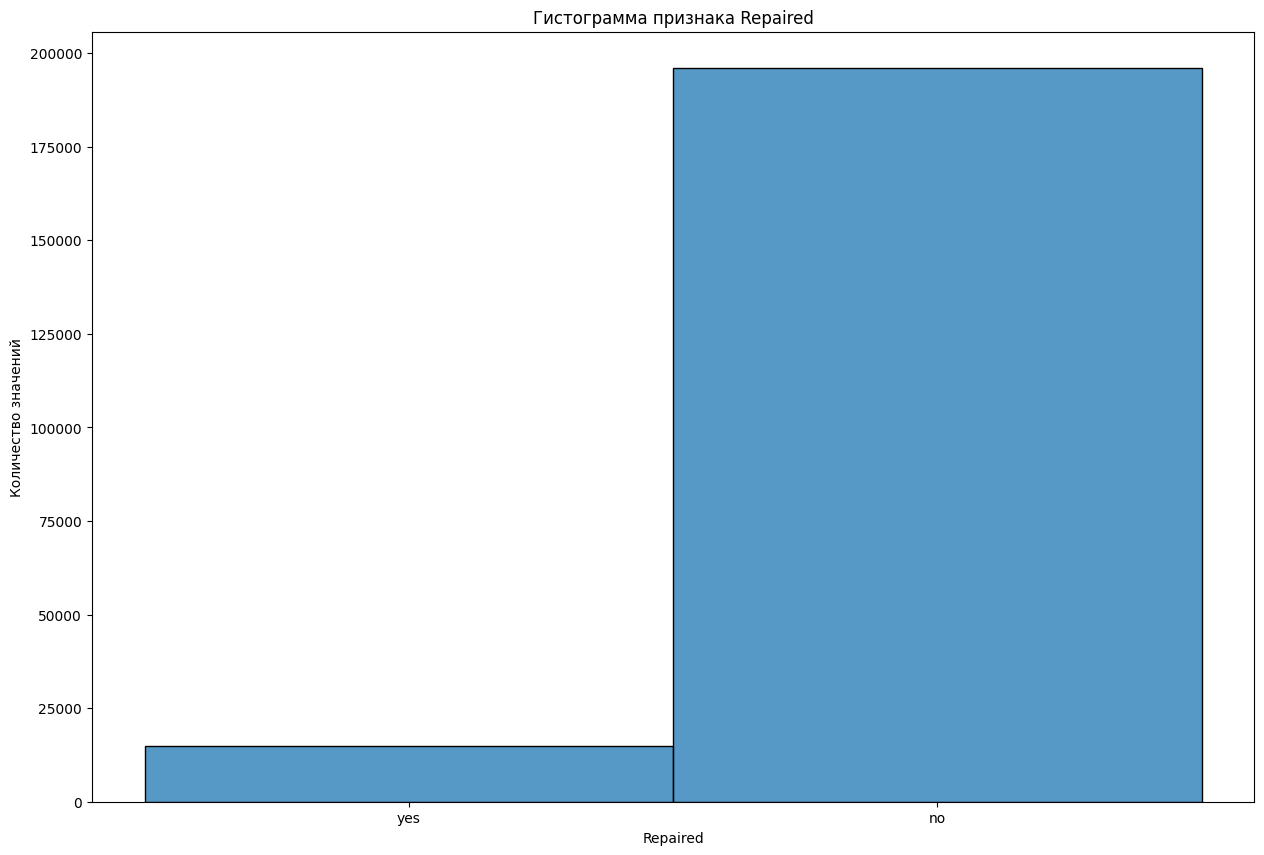

In [32]:
eda_graph('Repaired',2)

### Выводы исследовательский анализ
1. столбец `DateCrawled` 
    - удаляем как неинформативный
    - отмечаем год 2016 как верхнюю границу диапазона
2. столбец `Price` 
    - целевой признак 
    - среднее значение цены 4416$
    - max значение 20000$
    - удалили все значение (~12k) цены меньше 10$
3. столбец `VehicleType` 
    - категориальный признак
    - 8 классов
    - отсутсвующие значения заполним в Пайплайне
4. столбец `RegistrationYear`
    - ранговый признак
    - удалили все значения (8214) менше 1910 и больше 2016 года
5. столбец `Gearbox`
    - бинарный признак
    - отсутсвующие значения заполним в Пайплайне
6. столбец `Power`
    - ранговый признак
    - удалили значения (2342) мощности меньше 50 и больше 1000 л.с.
7. столбец `Model`
    - категориальный признак 
    - отсутсвующие значения заполним в Пайплайне
8. столбец `Kilometer`
    - ранговый признак
9. столбец `FuelType`
    - категориальный признак 
    - отсутсвующие значения заполним в Пайплайне
10. столбец `Brand`
    - категориальный признак 
    - отсутсвующие значения заполним в Пайплайне
11. столбец `Repaired`
    - бинарный признак
    - отсутсвующие значения заполним в Пайплайне

## Обучение моделей

In [33]:
data.duplicated().sum(), data.shape

(31094, (239247, 10))

In [34]:
data.drop_duplicates(inplace=True)
data.shape

(208153, 10)

In [35]:
data.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

In [36]:
ord_columns = ['Kilometer', 'RegistrationYear', 'Power', 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired', 'Brand']

In [37]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [38]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [39]:
data_preprocessor = ColumnTransformer(
    [
        ('ord', ord_pipe, ord_columns)
    ]
)

In [40]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [41]:
param_grid_dt = [
    {
        'models': [DecisionTreeRegressor(
            random_state=RANDOM_STATE)],
        'models__max_depth': [2, 5, 10]
    }
]

In [42]:
param_grid_lg = [
    {
        'models': [lgb.LGBMRegressor(random_state=RANDOM_STATE)],
        'models__num_leaves': range(5, 10),
        'models__max_depth': range(5, 10)
        
    }
]

In [43]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

In [44]:
# randomized_search = RandomizedSearchCV(
#     pipe_final, 
#     param_grid, 
#     cv=3,
#     scoring=rmse_scorer,
#     random_state=RANDOM_STATE,
#     n_iter = 5,
#     n_jobs=-1
# )

In [45]:
grid_search_dt = GridSearchCV(
    pipe_final, 
    param_grid_dt,
    cv=3,
    scoring=rmse_scorer,
)

In [46]:
grid_search_lg = GridSearchCV(
    pipe_final, 
    param_grid_lg,
    cv=3,
    scoring=rmse_scorer,
)

In [47]:
X = data.drop('Price', axis=1)  
y = data['Price']              

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_STATE)

In [48]:
grid_search_dt.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('ord',
                                                                         Pipeline(steps=[('simpleImputer_before_ord',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=nan)),
                                                                                         ('simpleImputer_after_ord',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         ['Kilometer',
                                                                          'RegistrationYear',
                                                                          'Power',
                                                                          'VehicleType',
                                                                          'Gearbox',
                                                                          'Model',
                                                                          'FuelType',
                                                                          'Repaired',
                                                                          'Brand'])])),
                                       ('models',
                                        DecisionTreeRegressor(random_state=123))]),
             param_grid=[{'models': [DecisionTreeRegressor(random_state=123)],
                          'models__max_depth': [2, 5, 10]}],
             scoring=make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict'))

In [49]:
grid_search_lg.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 111014, number of used features: 9
[LightGBM] [Info] Start training from score 5943.604608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 612
[LightGBM] [Info] Number of data points in the train set: 111015, number of used features: 9
[LightGBM] [Info] Start training from score 5967.699239
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('ord',
                                                                         Pipeline(steps=[('simpleImputer_before_ord',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=nan)),
                                                                                         ('simpleImputer_after_ord',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         ['Kilometer',
                                                                          'Regis...ar',
                                                                          'Power',
                                                                          'VehicleType',
                                                                          'Gearbox',
                                                                          'Model',
                                                                          'FuelType',
                                                                          'Repaired',
                                                                          'Brand'])])),
                                       ('models',
                                        DecisionTreeRegressor(random_state=123))]),
             param_grid=[{'models': [LGBMRegressor(random_state=123)],
                          'models__max_depth': range(5, 10),
                          'models__num_leaves': range(5, 10)}],
             scoring=make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict'))

## Анализ моделей

In [53]:
results_dt = (pd.DataFrame(grid_search_dt.cv_results_)
 .set_index('mean_test_score')
 .sort_index(ascending=False))

results_lg = (pd.DataFrame(grid_search_lg.cv_results_)
 .set_index('mean_test_score')
 .sort_index(ascending=False))

In [54]:
best_dt = results_dt.iloc[0:1,:][['param_models', 'mean_fit_time','mean_score_time', 'param_models__max_depth']]
best_dt.reset_index(inplace=True)
best_dt['mean_test_score'] = best_dt['mean_test_score'].abs()
best_dt

,mean_test_score,param_models,mean_fit_time,mean_score_time,param_models__max_depth
0,2121.791454,DecisionTreeRegressor(random_state=123),0.701062,0.184548,10


In [55]:
best_lg = results_lg.iloc[0:1,:][['param_models', 'mean_fit_time','mean_score_time', 'param_models__max_depth']]
best_lg.reset_index(inplace=True)
best_lg['mean_test_score'] = best_lg['mean_test_score'].abs()
best_lg

,mean_test_score,param_models,mean_fit_time,mean_score_time,param_models__max_depth
0,1917.567807,LGBMRegressor(random_state=123),1.020991,0.376346,9


In [56]:
start_time = time.time()
predicts = grid_search_dt.predict(X_test)
prediction_time = time.time() - start_time
scores = root_mean_squared_error(y_test, predicts)
print(f'RMSE лучшей модели на test:\
      {scores:.2f}')
print(f'Время предсказания лучшей модели:\
      {prediction_time:.2f}')

RMSE лучшей модели на test:      2113.34
Время предсказания лучшей модели:      0.21


In [57]:
dummy_reg = DummyRegressor(strategy="mean")
X_transformed_train = data_preprocessor.fit_transform(X_train)
X_transformed_test = data_preprocessor.transform(X_test)
dummy_reg.fit(X_transformed_train, y_train)
np.mean(dummy_reg.predict(X_transformed_test))

5952.400986055897

### Выводы по анализу моделей

Оценены 2 модели:
- DecisionTreeRegressor
- LGBMRegressor

Лучшие результаты оценки на кросс-валидации сведены в таблицы

TreeRegressor

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>mean_test_score</th>
      <th>param_models</th>
      <th>mean_fit_time</th>
      <th>mean_score_time</th>
      <th>param_models__max_depth</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>2121.791454</td>
      <td>DecisionTreeRegressor(random_state=123)</td>
      <td>0.82026</td>
      <td>0.187493</td>
      <td>10</td>
    </tr>
  </tbody>
</table>
</div>

LGBMRegressor
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>mean_test_score</th>
      <th>param_models</th>
      <th>mean_fit_time</th>
      <th>mean_score_time</th>
      <th>param_models__max_depth</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>1917.567807</td>
      <td>LGBMRegressor(random_state=123)</td>
      <td>1.150503</td>
      <td>0.380913</td>
      <td>9</td>
    </tr>
  </tbody>
</table>
</div>

## Выводы

### Предобработка
1) Получен датафрейм размерностью (354369,16)

2) Категории VehicleType, Gearbox, Model, FuelType, Repaired имеют пропуски данных, которые будут заполняться в пайплайне наиболее частым значением.

3) Удалены следующие неиформативные признаки 
- DateCrawled	
- RegistrationMonth
- DateCreated
- NumberOfPictures	
- LastSeen
- PostalCode

### Исследовательский анализ
1. столбец `DateCrawled` 
    - удаляем как неинформативный
    - отмечаем год 2016 как верхнюю границу диапазона
2. столбец `Price` 
    - целевой признак 
    - среднее значение цены 4416 долларов
    - max значение 20000 долларов
    - удалили все значение (~12k) цены меньше 10 долларов 
3. столбец `VehicleType` 
    - категориальный признак
    - 8 классов
    - отсутсвующие значения заполним в Пайплайне
4. столбец `RegistrationYear`
    - ранговый признак
    - удалили все значения (8214) менше 1910 и больше 2016 года
5. столбец `Gearbox`
    - бинарный признак
    - отсутсвующие значения заполним в Пайплайне
6. столбец `Power`
    - ранговый признак
    - удалили значения (2342) мощности меньше 50 и больше 1000 л.с.
7. столбец `Model`
    - категориальный признак 
    - отсутсвующие значения заполним в Пайплайне
8. столбец `Kilometer`
    - ранговый признак
9. столбец `FuelType`
    - категориальный признак 
    - отсутсвующие значения заполним в Пайплайне
10. столбец `Brand`
    - категориальный признак 
    - отсутсвующие значения заполним в Пайплайне
11. столбец `Repaired`
    - бинарный признак
    - отсутсвующие значения заполним в Пайплайне
    
    
### Подготовка данных

1. Распределены признаки для кодирования
- ОRD = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired', 'Brand','Kilometer', 'RegistrationYear', 'Power']
2. Построен Пайплайн с перебором параметров для двух моделей
- DecisionTreeRegressor
- LGBMRegressor
3. Проведено обучение валидационной выборки методом randomize_search

###  Анализ моделей
1.Оценены 2 модели:
- DecisionTreeRegressor
- LGBMRegressor

TreeRegressor

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>mean_test_score</th>
      <th>param_models</th>
      <th>mean_fit_time</th>
      <th>mean_score_time</th>
      <th>param_models__max_depth</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>2121.791454</td>
      <td>DecisionTreeRegressor(random_state=123)</td>
      <td>0.82026</td>
      <td>0.187493</td>
      <td>10</td>
    </tr>
  </tbody>
</table>
</div>

LGBMRegressor
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>mean_test_score</th>
      <th>param_models</th>
      <th>mean_fit_time</th>
      <th>mean_score_time</th>
      <th>param_models__max_depth</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>1917.567807</td>
      <td>LGBMRegressor(random_state=123)</td>
      <td>1.150503</td>
      <td>0.380913</td>
      <td>9</td>
    </tr>
  </tbody>
</table>
</div>

2.Результаты работы модели DummyRegressor
- стратегия 'mean'
- RMSE кросс-валидации:    5952.40

### Общий вывод 
Оптимальным решением соответствующим требованием клиента
- RMSE < 2500
- самое быстрое время обучения и предсказания

является модель DecisionTreeRegressor
- глубина ветвления 10
- RMSE = 2121
- самое быстрое время обучения 0,70 для моделей со сходными метриками 